In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-28 22:04:14 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-28 22:04:14 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-28 22:04:14 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-28 22:04:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-28 22:04:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-28 22:04:18 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-28 22:04:18 wandb.docker.auth DEBUG    No config file found


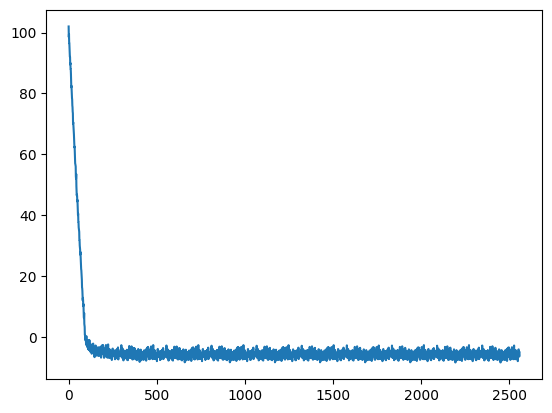

79


(True, True)

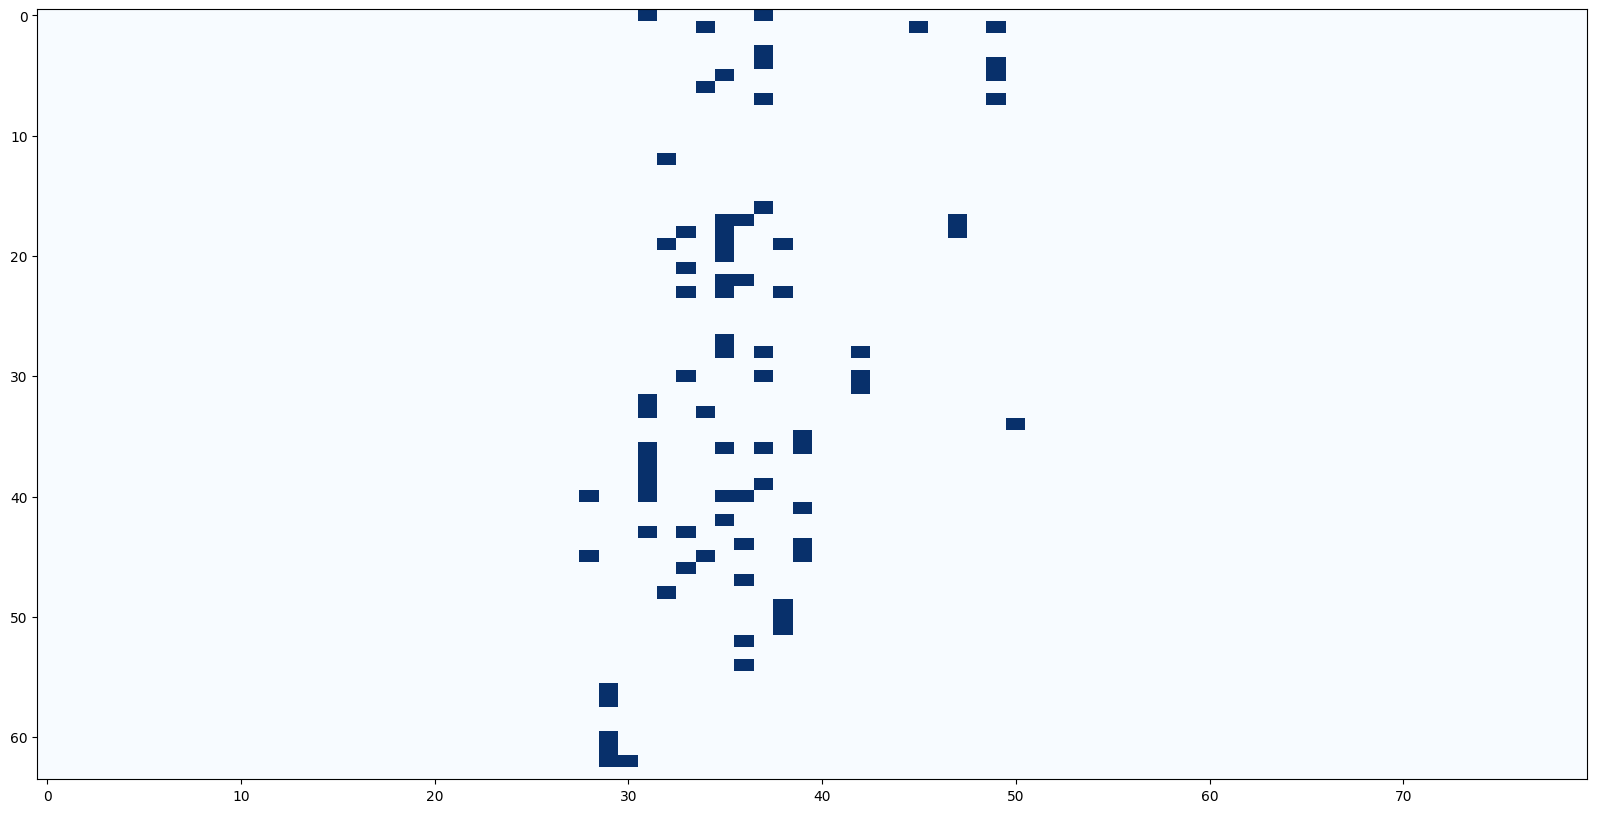

In [24]:
import sys

sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
from src.utils import env_utils
import os
import torch

plt.rcdefaults()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz",
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

filter_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
filter_heads = [(layer_idx, head_idx) for layer_idx, head_idx in filter_heads]
print(len(filter_heads))

HEADS = filter_heads

(35, 19) in HEADS, (35, 19) in filter_heads
# [(29, 3) in HEADS]

## Load LM and the Select Task

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-28 22:04:24 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-28 22:04:24 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-28 22:04:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-28 22:04:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-28 22:04:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-28 22:05:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-28 22:05:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-28 22:05:06 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
mt.model.layers[15].self_attn.config._attn_implementation

'eager'

In [7]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

from src.selection.data import SelectOneTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "selection",
        # "profession.json"
        # "nationality.json"
        "objects.json",
    )
)

print(select_task)

source, destination = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    # patch_category="fruit",
    # clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    
    patch_n_distractors=5,
    clean_n_distractors=5,
    
    distinct_options=False,
    shuffle_clean_options=True,
    mcqify=True
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(source.prompt(), ">>", source.obj)
print(destination.prompt(), ">>", destination.obj)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)

2025-10-28 22:05:21 src.selection.data WARNING  Passed clean_n_distractors=5. But distinct_options is False, so clean options will be same as patch options.
2025-10-28 22:05:21 src.selection.data INFO     clean_obj_idx=1 | ['Tape', 'Wardrobe', 'Willow', 'Suit', 'Chain', 'Keyboard']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-28 22:05:22 src.selection.data INFO     p. Wardrobe
q. Tape
r. Suit
s. Willow
t. Keyboard
u. Chain
Which among these objects mentioned above is a jewelry?
Answer:
2025-10-28 22:05:22 src.selection.data INFO     Pin | jewelry -> Chain | pred=['" u"[577] (p=0.684, logit=20.500)', '" Chain"[29625] (p=0.072, logit=18.250)', '" Option"[7104] (p=0.050, logit=17.875)', '" ("[320] (p=0.044, logit=17.750)', '" d"[294] (p=0.023, logit=17.125)']
2025-10-28 22:05:22 src.selection.data INFO     a. Tape
b. Wardrobe
c. Willow
d. Suit
e. Chain
f. Keyboard
Which among these objects mentioned above is a furniture?
Answer:
2025-10-28 22:05:22 src.selection.data INFO     Ottoman | furniture -> Wardrobe | pred=['" b"[293] (p=0.695, logit=20.375)', '" ("[320] (p=0.107, logit=18.500)', '" c"[272] (p=0.044, logit=17.625)', '" d"[294] (p=0.021, logit=16.875)', '" e"[384] (p=0.016, logit=16.625)']
p. Wardrobe
q. Tape
r. Suit
s. Willow
t. Keyboard
u. 

In [8]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

print(destination.prompt(), ">>", destination.obj)
print(source.prompt(), ">>", source.obj)

gold_sample = copy.deepcopy(source)
gold_sample.option_label_start_from = destination.option_label_start_from
gold_sample.options = copy.deepcopy(destination.options)

layer_idx, head_idx = (35, 19)

for sample in [source, destination, gold_sample]:
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        mt=mt,
        heads=[(35, 19)],
        query_index=-1,
    )

a. Tape
b. Wardrobe
c. Willow
d. Suit
e. Chain
f. Keyboard
Which among these objects mentioned above is a furniture?
Answer: >> Wardrobe
p. Wardrobe
q. Tape
r. Suit
s. Willow
t. Keyboard
u. Chain
Which among these objects mentioned above is a jewelry?
Answer: >> Chain
p. Wardrobe
q. Tape
r. Suit
s. Willow
t. Keyboard
u. Chain
Which among these objects mentioned above is a jewelry?
Answer: >> " u"
2025-10-28 22:05:23 src.selection.functional DEBUG    Predictions: ['" u"[577] (p=0.684, logit=20.500)', '" Chain"[29625] (p=0.072, logit=18.250)', '" Option"[7104] (p=0.050, logit=17.875)', '" ("[320] (p=0.044, logit=17.750)', '" r"[436] (p=0.023, logit=17.125)']
2025-10-28 22:05:23 src.selection.functional INFO     Combined attention matrix for all heads


a. Tape
b. Wardrobe
c. Willow
d. Suit
e. Chain
f. Keyboard
Which among these objects mentioned above is a furniture?
Answer: >> " b"
2025-10-28 22:05:23 src.selection.functional DEBUG    Predictions: ['" b"[293] (p=0.695, logit=20.375)', '" ("[320] (p=0.107, logit=18.500)', '" c"[272] (p=0.044, logit=17.625)', '" d"[294] (p=0.021, logit=16.875)', '" e"[384] (p=0.016, logit=16.625)']
2025-10-28 22:05:23 src.selection.functional INFO     Combined attention matrix for all heads


a. Tape
b. Wardrobe
c. Willow
d. Suit
e. Chain
f. Keyboard
Which among these objects mentioned above is a jewelry?
Answer: >> " u"
2025-10-28 22:05:23 src.selection.functional DEBUG    Predictions: ['" e"[384] (p=0.594, logit=20.750)', '" ("[320] (p=0.170, logit=19.500)', '" c"[272] (p=0.043, logit=18.125)', '" Chain"[29625] (p=0.030, logit=17.750)', '" b"[293] (p=0.023, logit=17.500)']
2025-10-28 22:05:23 src.selection.functional INFO     Combined attention matrix for all heads


## Debug OV Patching Code

In [9]:
from src.utils.typing import TokenizerOutput

source_tokenized = prepare_input(
    prompts=[
        source.prompt(), 
        destination.prompt()
    ], tokenizer=mt
)
destination_tokenized = prepare_input(
    prompts=[
        destination.prompt(), 
        source.prompt()
    ], tokenizer=mt
)

In [10]:
t = torch.randn(3, 4)
type(t[0][0]) is torch.Tensor

True

In [11]:
from typing import Optional
from typing import Callable
from src.hooking.llama_attention import apply_rotary_pos_emb, repeat_kv
import types

mt.set_attn_implementation("eager")
def eager_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = torch.nn.functional.dropout(attn_weights, p=dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights


def attn_per_head(
    o_proj: torch.nn.modules.linear.Linear,
    attn_output: torch.Tensor,
    set_attn_contributions: dict[int, tuple[float, dict[int, torch.Tensor]]] = {}, # head_idx -> token_idx -> (mask, ov_contribution)
):
    # print(attn_output.size())
    b, q_len, n_head, h_dim = attn_output.size()
    o_proj_weight_split = o_proj.weight.view(o_proj.out_features, n_head, h_dim)

    # print(f"{o_proj_weight_split.size()=}")
    # print(f"{attn_output.size()=}")

    per_head_contributions = []
    for head_idx in range(n_head):
        # calculate the contribution per head
        attn_output_per_head = attn_output[
            :, :, head_idx, :
        ]  # shape: (b, q_len, h_dim)
        attn_output_per_head = attn_output_per_head.to(
            o_proj_weight_split[:, head_idx, :].dtype
        ).to(o_proj_weight_split[:, head_idx, :].device)
        projected_per_head = (
            attn_output_per_head @ o_proj_weight_split[:, head_idx, :].T
        )  # shape: (b, q_len, out_features)

        # *Patch the contributions if specified
        if head_idx in set_attn_contributions:
            mask = set_attn_contributions[head_idx][0]
            for token_idx, ov_contribution in set_attn_contributions[head_idx][1].items():
                # print(f"Patching head {head_idx} token {token_idx}")
                orig = projected_per_head[:, token_idx, :].clone().detach()
                device = orig.device
                mask = mask.to(device) if isinstance(mask, torch.Tensor) else mask
                ov_contribution = ov_contribution.to(device)
                patch = mask * ov_contribution + (1 - mask) * orig

                projected_per_head[:, token_idx, :] = patch.to(
                    orig.dtype
                ).to(orig.device)

        per_head_contributions.append(projected_per_head)
        # print(f"{projected_per_head.size()=}")

    per_head_contributions = torch.stack(
        per_head_contributions, dim=1
    )  # shape: (b, n_head, q_len, out_features)

    attn_output = per_head_contributions.sum(dim=1)  # shape: (b, q_len, out_features)

    # print(f"{attn_output.size()=} | {per_head_contributions.size()=}")
    return attn_output, per_head_contributions


def attn_forward_with_custom_attn_pattern(
    block_name: str | None = None,
    set_attn_contributions: dict[int, tuple[float, dict[int, torch.Tensor]]] = {}, # head_idx -> token_idx -> (mask, ov_contribution)
    get_attn_contributions: list[tuple[int, int]] = [],  # list of (head_idx, token_idx)
    cache_attn_contributions: dict[tuple[int], dict[int, torch.Tensor]] = {}, # head_idx -> token_idx -> ov_contribution
):
    def forward_modified(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_values = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_values is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_values.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface: Callable = eager_attention_forward
        if self.config._attn_implementation != "eager":
            assert False, "Not implemented yet!"
            # attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        if block_name is not None:
            # only for debugging
            print(f"{block_name}")

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            **kwargs,
        )

        if len(set_attn_contributions) > 0 or len(get_attn_contributions) > 0:
            __attn_output, per_head_contributions = attn_per_head(
                self.o_proj,
                attn_output,
                set_attn_contributions=set_attn_contributions,
            )

            # print(f"{__attn_output.size()=} | {per_head_contributions.size()=}")

            if len(get_attn_contributions) > 0:
                for head_idx, token_idx in get_attn_contributions:
                    if head_idx not in cache_attn_contributions:
                        cache_attn_contributions[head_idx] = {}
                    cache_attn_contributions[head_idx][token_idx] = per_head_contributions[
                        :, head_idx, token_idx, :
                    ]

        if len(set_attn_contributions) > 0:
            attn_output = __attn_output
        else:
            #* clean implementation
            attn_output = attn_output.reshape(*input_shape, -1).contiguous()
            attn_output = self.o_proj(attn_output)

        # print(f"{attn_output.size()=}, {attn_weights.size()=}")

        return attn_output, attn_weights
    
    return forward_modified

# mt.reset_forward()
# for layer_idx in range(mt.config.num_hidden_layers):
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)
#     attn_block.forward = types.MethodType(attn_forward_with_custom_attn_pattern(), attn_block)

In [12]:
from src.functional import get_module_nnsight, interpret_logits, free_gpu_cache
from itertools import product

####################################################
query_mapping = {-1: -1}
# heads = [(35, 19)]
heads = optimized_heads
####################################################

free_gpu_cache()
heads_per_layer = {}
for layer_idx, head_idx in heads:
    if layer_idx not in heads_per_layer:
        heads_per_layer[layer_idx] = []
    heads_per_layer[layer_idx].append(head_idx)

source_ov_contributions = {}

mt.reset_forward()
for layer_idx in heads_per_layer.keys():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = get_module_nnsight(mt._model, attn_block_name)
    source_ov_contributions[layer_idx] = {}
    attn_block.forward = types.MethodType(
        attn_forward_with_custom_attn_pattern(
            # block_name=attn_block_name,
            set_attn_contributions={},
            get_attn_contributions=list(product(
                heads_per_layer[layer_idx],
                query_mapping.keys(), # source_token_indices
            )),
            cache_attn_contributions=source_ov_contributions[layer_idx],
        ),
        attn_block,
    )

source_outputs = mt._model(**source_tokenized)
mt.reset_forward()

logits = source_outputs.logits[:, -1, :]
logger.debug(f"{logits.size()=}")

for layer_idx, head_idx in heads:
    logger.debug(
        f"L{layer_idx} H{head_idx}: {source_ov_contributions[layer_idx][head_idx][-1].size()}"
    )

interpret_logits(
    logits=logits[0],
    tokenizer=mt.tokenizer,
    k=15,
)

2025-10-28 22:05:36 __main__ DEBUG    logits.size()=torch.Size([2, 128256])
2025-10-28 22:05:36 __main__ DEBUG    L28 H40: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L28 H45: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L29 H56: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L29 H57: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L29 H60: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L29 H61: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L29 H62: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L30 H62: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L31 H0: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L31 H32: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L31 H33: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L31 H36: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__ DEBUG    L31 H37: torch.Size([2, 8192])
2025-10-28 22:05:36 __main__

[PredictedToken(token=' u', prob=0.69140625, logit=20.5, token_id=577, metadata=None),
 PredictedToken(token=' Chain', prob=0.07275390625, logit=18.25, token_id=29625, metadata=None),
 PredictedToken(token=' Option', prob=0.044189453125, logit=17.75, token_id=7104, metadata=None),
 PredictedToken(token=' (', prob=0.044189453125, logit=17.75, token_id=320, metadata=None),
 PredictedToken(token=' r', prob=0.023681640625, logit=17.125, token_id=436, metadata=None),
 PredictedToken(token=' d', prob=0.0208740234375, logit=17.0, token_id=294, metadata=None),
 PredictedToken(token=' q', prob=0.0098876953125, logit=16.25, token_id=2874, metadata=None),
 PredictedToken(token=' A', prob=0.00872802734375, logit=16.125, token_id=362, metadata=None),
 PredictedToken(token=' c', prob=0.0076904296875, logit=16.0, token_id=272, metadata=None),
 PredictedToken(token=' b', prob=0.005279541015625, logit=15.625, token_id=293, metadata=None),
 PredictedToken(token=' The', prob=0.005279541015625, logit=15.6

In [13]:
free_gpu_cache()

In [14]:
mt.reset_forward()

destination_ov_contributions = {}

for layer_idx in heads_per_layer.keys():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = get_module_nnsight(mt._model, attn_block_name)
    destination_ov_contributions[layer_idx] = {}
    attn_block.forward = types.MethodType(
        attn_forward_with_custom_attn_pattern(
            # block_name=attn_block_name,
            set_attn_contributions={head_idx: (1.0, source_ov_contributions[layer_idx][head_idx]) for head_idx in heads_per_layer[layer_idx]},
            get_attn_contributions=list(product(
                heads_per_layer[layer_idx],
                query_mapping.values(), # destination_token_indices
            )),
            cache_attn_contributions=destination_ov_contributions[layer_idx],
        ),
        attn_block,
    )

patched_outputs = mt._model(**destination_tokenized)
mt.reset_forward()

logits = patched_outputs.logits[:, -1, :]
logger.debug(f"{logits.size()=}")
interpret_logits(
    logits=logits[0],
    tokenizer=mt.tokenizer,
    k=15,
)

2025-10-28 22:05:49 __main__ DEBUG    logits.size()=torch.Size([2, 128256])


[PredictedToken(token=' e', prob=0.50390625, logit=19.75, token_id=384, metadata=None),
 PredictedToken(token=' (', prob=0.1279296875, logit=18.375, token_id=320, metadata=None),
 PredictedToken(token=' d', prob=0.068359375, logit=17.75, token_id=294, metadata=None),
 PredictedToken(token=' a', prob=0.05322265625, logit=17.5, token_id=264, metadata=None),
 PredictedToken(token=' c', prob=0.04150390625, logit=17.25, token_id=272, metadata=None),
 PredictedToken(token=' Option', prob=0.0322265625, logit=17.0, token_id=7104, metadata=None),
 PredictedToken(token=' b', prob=0.022216796875, logit=16.625, token_id=293, metadata=None),
 PredictedToken(token=' None', prob=0.0196533203125, logit=16.5, token_id=2290, metadata=None),
 PredictedToken(token=' The', prob=0.01190185546875, logit=16.0, token_id=578, metadata=None),
 PredictedToken(token=' Answer', prob=0.00927734375, logit=15.75, token_id=22559, metadata=None),
 PredictedToken(token=' Only', prob=0.00872802734375, logit=15.6875, token

In [15]:
for layer_idx, head_idx in heads:
    logger.debug(
        f"L{layer_idx} H{head_idx}: {torch.allclose(source_ov_contributions[layer_idx][head_idx][-1], destination_ov_contributions[layer_idx][head_idx][-1])}"
    )

2025-10-28 22:05:49 __main__ DEBUG    L28 H40: True
2025-10-28 22:05:49 __main__ DEBUG    L28 H45: True
2025-10-28 22:05:49 __main__ DEBUG    L29 H56: True
2025-10-28 22:05:49 __main__ DEBUG    L29 H57: True
2025-10-28 22:05:49 __main__ DEBUG    L29 H60: True
2025-10-28 22:05:49 __main__ DEBUG    L29 H61: True
2025-10-28 22:05:49 __main__ DEBUG    L29 H62: True


2025-10-28 22:05:49 __main__ DEBUG    L30 H62: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H0: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H32: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H33: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H36: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H37: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H38: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H39: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H40: True
2025-10-28 22:05:49 __main__ DEBUG    L31 H43: True
2025-10-28 22:05:49 __main__ DEBUG    L32 H12: True
2025-10-28 22:05:49 __main__ DEBUG    L32 H19: True
2025-10-28 22:05:49 __main__ DEBUG    L32 H48: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H18: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H21: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H23: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H30: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H43: True
2025-10-28 22:05:49 __main__ DEBUG    L33 H46: True
2025-10-28 22

In [16]:
from src.utils.typing import SVD
from src.attention import visualize_attn_matrix

def get_ov_contributions(
    mt: ModelandTokenizer,
    sample_tokenized: TokenizerOutput,
    heads_per_layer: dict[int, list[int]],
    query_indices: list[int],
    model_kwargs: dict = {},
):
    ov_contributions = {}

    mt.reset_forward()
    for layer_idx in heads_per_layer.keys():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = get_module_nnsight(mt._model, attn_block_name)
        ov_contributions[layer_idx] = {}
        attn_block.forward = types.MethodType(
            attn_forward_with_custom_attn_pattern(
                # block_name=attn_block_name,
                set_attn_contributions={},
                get_attn_contributions=list(
                    product(
                        heads_per_layer[layer_idx],
                        query_indices,  # source_token_indices
                    )
                ),
                cache_attn_contributions=ov_contributions[layer_idx],
            ),
            attn_block,
        )
    outputs = mt._model(**sample_tokenized, **model_kwargs)
    mt.reset_forward()

    return ov_contributions, outputs


def patch_ov_contributions(
    mt: ModelandTokenizer,
    destination_tokenized: TokenizerOutput,
    set_ov_contributions: dict[int, dict[int, dict[int, torch.Tensor]]],
    query_mappings: dict[int, int] = {-1: -1},
    masks: torch.Tensor | None = None,
    model_kwargs: dict = {},
    with_grad: bool = False,
):
    grad_env = torch.enable_grad if with_grad else torch.no_grad

    set_ov_contributions_masked = {}
    for layer_idx in set_ov_contributions.keys():
        set_ov_contributions_masked[layer_idx] = {}
        for head_idx in set_ov_contributions[layer_idx].keys():
            mask = 1.0 if masks is None else masks[layer_idx][head_idx]
            set_ov_contributions_masked[layer_idx][head_idx] = (mask, {
                destination_token_idx: set_ov_contributions[layer_idx][head_idx][source_token_idx]
                for source_token_idx, destination_token_idx in query_mappings.items()
            })

    with grad_env():
        mt.reset_forward()
        for layer_idx in set_ov_contributions.keys():
            attn_block_name = mt.attn_module_name_format.format(layer_idx)
            attn_block = get_module_nnsight(mt._model, attn_block_name)
            attn_block.forward = types.MethodType(
                attn_forward_with_custom_attn_pattern(
                    # block_name=attn_block_name,
                    set_attn_contributions=set_ov_contributions_masked[layer_idx],
                ),
                attn_block,
            )

        patched_outputs = mt._model(**destination_tokenized, **model_kwargs)

    if not with_grad:
        mt.reset_forward()
    # else don't reset here. reset after the optimization step

    return patched_outputs
    

def apply_ov_patching(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    heads: list[tuple[int, int]],
    query_mappings: dict[int, int] = {-1: -1},
    model_kwargs: dict = {},
    masks: torch.Tensor | None = None,
    with_grad: bool = False,
):
    heads_per_layer = {}
    for layer_idx, head_idx in sorted(heads):
        if layer_idx not in heads_per_layer:
            heads_per_layer[layer_idx] = []
        heads_per_layer[layer_idx].append(head_idx)

    source_ov_contributions, source_outputs = get_ov_contributions(
        mt=mt,
        sample_tokenized=source_tokenized,
        heads_per_layer=heads_per_layer,
        query_indices=list(query_mappings.keys()),
        model_kwargs=model_kwargs,
    )

    patched_outputs = patch_ov_contributions(
        mt=mt,
        destination_tokenized=destination_tokenized,
        set_ov_contributions=source_ov_contributions,
        query_mappings=query_mappings,
        masks=masks,
        model_kwargs=model_kwargs,
        with_grad=with_grad,
    )
    
    # else don't reset here. reset after the optimization step
    return patched_outputs


heads = optimized_heads 
output_test = apply_ov_patching(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    heads=optimized_heads,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in heads
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

tokens = [
    mt.tokenizer.decode(token_id)
    for token_id in destination_tokenized.input_ids[batch_idx]
]

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=tokens,
    q_index=-1,
    start_from=tokens.index(mt.tokenizer.bos_token) + 1,
)

logits = output_test.logits[batch_idx, -1, :]
interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=15,
)

attentions_test.shape=torch.Size([80, 2, 64, 38, 38])


[PredictedToken(token=' e', prob=0.50390625, logit=19.75, token_id=384, metadata=None),
 PredictedToken(token=' (', prob=0.1279296875, logit=18.375, token_id=320, metadata=None),
 PredictedToken(token=' d', prob=0.068359375, logit=17.75, token_id=294, metadata=None),
 PredictedToken(token=' a', prob=0.05322265625, logit=17.5, token_id=264, metadata=None),
 PredictedToken(token=' c', prob=0.04150390625, logit=17.25, token_id=272, metadata=None),
 PredictedToken(token=' Option', prob=0.0322265625, logit=17.0, token_id=7104, metadata=None),
 PredictedToken(token=' b', prob=0.022216796875, logit=16.625, token_id=293, metadata=None),
 PredictedToken(token=' None', prob=0.0196533203125, logit=16.5, token_id=2290, metadata=None),
 PredictedToken(token=' The', prob=0.01190185546875, logit=16.0, token_id=578, metadata=None),
 PredictedToken(token=' Answer', prob=0.00927734375, logit=15.75, token_id=22559, metadata=None),
 PredictedToken(token=' Only', prob=0.00872802734375, logit=15.6875, token

## Training Set

In [ ]:
from typing import Literal
from src.selection.data import CounterFactualSamplePair
from tqdm.auto import tqdm

option_config: Literal["same", "different"] = "different"

train_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    "objects",
    option_config,
    "samples",
    "train"
)
train_limit = 1024
start_from = 1

os.makedirs(train_samples_save_path, exist_ok=True)
train_set = []

for sample_idx in tqdm(range(train_limit)):
    source, destination = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors= random.randint(4, 6),
        distinct_options=(option_config == "different"),
        shuffle_clean_options=True,
        mcqify=True
    )
    train_set.append((destination, source))

    cf_pair = CounterFactualSamplePair(
        patch_sample=source,
        clean_sample=destination,
    )
    cf_pair.detensorize()

    with open(
        os.path.join(train_samples_save_path, f"{start_from + sample_idx: 05d}.json"), "w"
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=4)

len(train_set)

  0%|          | 0/1024 [00:00<?, ?it/s]

2025-10-27 16:53:38 src.selection.data INFO     clean_obj_idx=4 | ['Clarinet', 'Bat', 'Asparagus', 'Motorcycle', 'Giraffe']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-27 16:53:39 src.selection.data INFO     p. Giraffe
q. Clarinet
r. Motorcycle
s. Asparagus
t. Bat
Which among these objects mentioned above is a vehicle?
Answer:
2025-10-27 16:53:39 src.selection.data INFO     Tractor | vehicle -> Motorcycle | pred=['" r"[436] (p=0.480, logit=20.250)', '" Option"[7104] (p=0.156, logit=19.125)', '" Motorcycle"[70762] (p=0.138, logit=19.000)', '" ("[320] (p=0.065, logit=18.250)', '" Among"[22395] (p=0.035, logit=17.625)']
2025-10-27 16:53:39 src.selection.data INFO     a. Clarinet
b. Bat
c. Asparagus
d. Motorcycle
e. Giraffe
Which among these objects mentioned above is a animal?
Answer:
2025-10-27 16:53:39 src.selection.data INFO     Horse | animal -> Giraffe | pred=['" e"[384] (p=0.473, logit=20.375)', '" ("[320] (p=0.197, logit=19.500)', '" b"[293] (p=0.093, logit=18.750

KeyboardInterrupt: 

In [17]:
from src.selection.data import CounterFactualSamplePair
import random
from typing import Literal

train_set = []
train_limit = 1024

option_config: Literal["same", "different"] = "same"

train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    "objects",
    option_config,
    "samples",
    "train"
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template

    clean_sample = cf_pair.clean_sample
    patch_sample = cf_pair.patch_sample

    # #! make pointer target
    # clean_sample.metadata['track_type_obj'] = clean_sample.options[patch_sample.obj_idx]
    # clean_sample.metadata['track_type_obj_token_id'] = get_first_token_id(
    #     name = chr(ord(clean_sample.option_label_start_from) + patch_sample.obj_idx),
    #     tokenizer=mt.tokenizer,
    #     prefix=" "
    # )

    train_set.append((clean_sample, patch_sample))

len(train_set)

2025-10-28 22:06:07 __main__ INFO     Found 1024 sample files


1024

In [21]:
destination, source = random.choice(train_set)
print("Destination:", destination.prompt(), ">>", destination.obj, ">>", mt.tokenizer.decode(destination.ans_token_id))
print("Source:", source.prompt(), ">>", source.obj, ">>", mt.tokenizer.decode(source.ans_token_id))

print("\n")
print(f"Target: {destination.metadata['track_type_obj']} | {mt.tokenizer.decode(destination.metadata['track_type_obj_token_id'])}")

Destination: a. Accordion
b. Toothbrush
c. Tennis ball
d. Peach
e. Motorcycle
f. Bear
Which among these objects mentioned above is a fruit?
Answer: >> Peach >>  d
Source: p. Motorcycle
q. Accordion
r. Bear
s. Toothbrush
t. Tennis ball
u. Peach
Which among these objects mentioned above is a sport equipment?
Answer: >> Tennis ball >>  t


Target: Tennis ball |  c


## Validation Set

In [59]:
from typing import Literal
from src.selection.data import CounterFactualSamplePair
from tqdm.auto import tqdm

option_config: Literal["same", "different"] = "different"

data_type = "profession"
# data_type = "objects"

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    data_type,
    option_config,
    "samples",
    "validation"
)
validation_limit = 512
start_from = 1

os.makedirs(validation_samples_save_path, exist_ok=True)
validation_set = []

for sample_idx in tqdm(range(validation_limit)):
    source, destination = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors= random.randint(5, 7),
        distinct_options=(option_config == "different"),
        shuffle_clean_options=True,
        mcqify=True
    )
    validation_set.append((destination, source))

    cf_pair = CounterFactualSamplePair(
        patch_sample=source,
        clean_sample=destination,
    )
    cf_pair.detensorize()

    with open(
        os.path.join(validation_samples_save_path, f"{start_from + sample_idx: 05d}.json"), "w"
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=4)

len(validation_set)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-10-29 10:08:47 src.selection.data INFO     clean_obj_idx=0 | ['Watermelon', 'Motorcycle', 'Football', 'Suit', 'Anklet', 'Ottoman', 'Harp']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-29 10:08:48 src.selection.data INFO     p. Surfboard
q. Harmonica
r. Bookshelf
s. Shorts
t. Raspberry
u. Van
v. Sink
Which among these objects mentioned above is a music instrument?
Answer:
2025-10-29 10:08:48 src.selection.data INFO     Harp | music instrument -> Harmonica | pred=['" q"[2874] (p=0.574, logit=21.000)', '" Harmon"[40759] (p=0.212, logit=20.000)', '" The"[578] (p=0.053, logit=18.625)', '" Option"[7104] (p=0.047, logit=18.500)', '" ("[320] (p=0.037, logit=18.250)']
2025-10-29 10:08:48 src.selection.data INFO     a. Watermelon
b. Motorcycle
c. Football
d. Suit
e. Anklet
f. Ottoman
g. Harp
Which among these objects mentioned above is a fruit?
Answer:
2025-10-29 10:08:48 src.selection.data INFO     Pear | fruit -> Watermelon | pred=['" a"[264] (p=0.676, logit=22.500)', '" 

512

In [58]:
from src.selection.data import CounterFactualSamplePair
import random

option_config: Literal["same", "different"] = "different"

# data_type = "profession"
data_type = "objects"

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    data_type,
    option_config,
    "samples",
    "validation"
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template

    clean_sample = cf_pair.clean_sample
    patch_sample = cf_pair.patch_sample

    #! make pointer target
    #TODO: should be commented out in case you are interested in the concept, not the pointer
    #TODO: maybe this should be a flag?
    # clean_sample.metadata['track_type_obj'] = clean_sample.options[patch_sample.obj_idx]
    # clean_sample.metadata['track_type_obj_token_id'] = get_first_token_id(
    #     name = chr(ord(clean_sample.option_label_start_from) + patch_sample.obj_idx),
    #     tokenizer=mt.tokenizer,
    #     prefix=" "
    # )

    validation_set.append((clean_sample, patch_sample))

len(validation_set)

FileNotFoundError: [Errno 2] No such file or directory: '/disk/u/arnab/Codes/Projects/retrieval/results/selection/ov_patching/Llama-3.3-70B-Instruct/objects/different/samples/validation'

In [19]:
destination, source = validation_set[25]
print("Destination:", destination.prompt(), ">>", destination.obj, ">>", mt.tokenizer.decode(destination.ans_token_id))
print("Source:", source.prompt(), ">>", source.obj, ">>", mt.tokenizer.decode(source.ans_token_id))

print("\n")
print(f"Target: {destination.metadata['track_type_obj']} | {mt.tokenizer.decode(destination.metadata['track_type_obj_token_id'])}")

Destination: p. Magnolia
q. Church
r. Iris
s. Paper
t. Flute
u. Brooch
Which among these objects mentioned above is a music instrument?
Answer: >> Flute >>  t
Source: a. Magnolia
b. Brooch
c. Paper
d. Flute
e. Church
f. Iris
Which among these objects mentioned above is a office supply?
Answer: >> Paper >>  c


Target: Paper |  s


## optimization logic

In [20]:
# source_tokenized = prepare_input(
#     prompts=[
#         source.prompt(), 
#         # destination.prompt()
#     ], tokenizer=mt
# )
# destination_tokenized = prepare_input(
#     prompts=[
#         destination.prompt(), 
#         # source.prompt()
#     ], tokenizer=mt
# )

In [21]:
from src.utils.typing import TokenizerOutput

prompts = []
clean_samples, patch_samples = zip(*validation_set[:16])

prompts.extend([sample.prompt() for sample in clean_samples])
prompts.extend([sample.prompt() for sample in patch_samples])
tokenized = prepare_input(prompts=prompts, tokenizer=mt)
destination_tokenized = TokenizerOutput(
    data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
)
source_tokenized = TokenizerOutput(
    data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
)

In [22]:
import baukit
from src.utils.typing import PathLike, SVD
from torch.optim import AdamW
from src.functional import free_gpu_cache, get_module_nnsight
from src.tokens import TokenizerOutput
from typing import Literal
from src.selection.optimization import (
    promote_target_suppress_distractors,
    match_gold_logit_distribution,
)
import numpy as np
from src.attention import visualize_attn_matrix
import types


heads = optimized_heads 
output_test = apply_ov_patching(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    heads=optimized_heads,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in heads
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

tokens = [
    mt.tokenizer.decode(token_id)
    for token_id in destination_tokenized.input_ids[batch_idx]
]

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=tokens,
    q_index=-1,
    start_from=tokens.index(mt.tokenizer.bos_token) + 1,
)

logits = output_test.logits[batch_idx, -1, :]
interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=15,
)

attentions_test.shape=torch.Size([80, 16, 64, 48, 48])


[PredictedToken(token=' d', prob=0.61328125, logit=21.75, token_id=294, metadata=None),
 PredictedToken(token=' (', prob=0.224609375, logit=20.75, token_id=320, metadata=None),
 PredictedToken(token=' The', prob=0.056884765625, logit=19.375, token_id=578, metadata=None),
 PredictedToken(token=' Letter', prob=0.023681640625, logit=18.5, token_id=27757, metadata=None),
 PredictedToken(token=' Option', prob=0.0162353515625, logit=18.125, token_id=7104, metadata=None),
 PredictedToken(token=' Answer', prob=0.0098876953125, logit=17.625, token_id=22559, metadata=None),
 PredictedToken(token=' D', prob=0.00872802734375, logit=17.5, token_id=423, metadata=None),
 PredictedToken(token=' f', prob=0.0076904296875, logit=17.375, token_id=282, metadata=None),
 PredictedToken(token=' Only', prob=0.0059814453125, logit=17.125, token_id=8442, metadata=None),
 PredictedToken(token=' A', prob=0.003631591796875, logit=16.625, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.003204345

In [23]:
from src.functional import get_hs, interpret_logits
from src.selection.data import get_options_for_answer


@torch.no_grad()
def validate_ov_patching_on_sample_pair(
    mt: ModelandTokenizer,
    destination_sample: SelectionSample,
    source_sample: SelectionSample,
    heads: list[tuple[int, int]],
    token_mapping: dict[int, int] = {-1: -1},  # source_idx -> destination_idx
    must_track_tokens: list[int] = [],
    return_clean_predictions: bool = False,
    debug=False,
):
    destination_tokenized = prepare_input(
        prompts=destination_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )
    source_tokenized = prepare_input(
        prompts=source_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )

    # destination_offset_mapping = destination_tokenized.pop("offset_mapping")[0]
    # source_offset_mapping = source_tokenized.pop("offset_mapping")[0]

    ret_dict = {
        "source_sample": source_sample,
        "destination_sample": destination_sample,
    }
    logit_location = (mt.lm_head_name, -1)

    if return_clean_predictions or debug:
        source_hidden_states = get_hs(
            mt=mt,
            input=source_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        source_pred, source_track = interpret_logits(
            tokenizer=mt,
            logits=source_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(source_sample)
            ]
            + must_track_tokens,
        )

        destination_hidden_states = get_hs(
            mt=mt,
            input=destination_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        destination_pred, destination_track = interpret_logits(
            tokenizer=mt,
            logits=destination_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
            ]
            + must_track_tokens,
        )

        if return_clean_predictions:
            ret_dict["source_predictions"] = source_pred
            ret_dict["source_track"] = source_track
            ret_dict["destination_predictions"] = destination_pred
            ret_dict["destination_track"] = destination_track
        if debug:
            print(
                f"Destination: {destination.prompt()} >> Ans: {mt.tokenizer.decode(destination_sample.ans_token_id)}"
            )
            destination_attn_pattern = verify_head_patterns(
                prompt=destination_sample.prompt(),
                tokenized_prompt=destination_tokenized,
                mt=mt,
                heads=heads,
                query_index=-1,
            )

            print(
                f"Source: {source.prompt()} >> Ans: {mt.tokenizer.decode(source_sample.ans_token_id)}"
            )
            source_attn_pattern = verify_head_patterns(
                prompt=source_sample.prompt(),
                tokenized_prompt=source_tokenized,
                mt=mt,
                heads=heads,
                query_index=-1,
            )

    patched_output = apply_ov_patching(
        mt=mt,
        source_tokenized=source_tokenized,
        destination_tokenized=destination_tokenized,
        heads=heads,
        query_mappings=token_mapping,
        model_kwargs={"output_attentions": debug},
    )

    logits = patched_output.logits[:, -1, :]
    track_tokens = get_options_for_answer(destination_sample)
    track_token_ids = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in track_tokens
    ] + [
        source_sample.ans_token_id
    ]  # also track source ans
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt,
        logits=logits.squeeze(),
        interested_tokens=track_token_ids + must_track_tokens,
    )

    ret_dict["patched_predictions"] = patched_pred
    ret_dict["patched_track"] = patched_track

    if debug:
        attentions = [attn.cuda() for attn in patched_output.attentions]
        attentions = torch.stack(attentions)  # (layers, heads, tokens, tokens)
        print(f"{attentions.shape=}")

        batch_idx = 0
        mean_attention = [
            attentions[layer_idx, batch_idx, head_idx]
            for layer_idx, head_idx in heads
        ]
        mean_attention = torch.stack(mean_attention).mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=mean_attention,
            tokens=[
                mt.tokenizer.decode(token_id)
                for token_id in destination_tokenized.input_ids[batch_idx]
            ],
            q_index=-1,
            start_from=1,
        )

        logger.debug("-" * 100)
        logger.debug(
            f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
        )
        logger.debug(f"Patched pred : {[str(pred) for pred in patched_pred]}")
        logger.debug(
            f"Patched track: {[str(pred) for tok_id, (rank, pred) in patched_track.items()]}"
        )
        logger.debug("-" * 100)

    return ret_dict



mt.reset_forward()
ret_dict = validate_ov_patching_on_sample_pair(
    mt=mt,
    destination_sample=destination,
    source_sample=source,
    token_mapping={-1: -1},
    heads=optimized_heads,
    must_track_tokens=[
        source.ans_token_id,
        destination.metadata["track_type_obj_token_id"],
    ],
    return_clean_predictions=True,
    debug=True,
)

Destination: p. Magnolia
q. Church
r. Iris
s. Paper
t. Flute
u. Brooch
Which among these objects mentioned above is a music instrument?
Answer: >> Ans:  t
2025-10-28 22:06:27 src.selection.functional DEBUG    Predictions: ['" t"[259] (p=0.467, logit=20.000)', '" Option"[7104] (p=0.194, logit=19.125)', '" ("[320] (p=0.092, logit=18.375)', '" Fl"[3061] (p=0.081, logit=18.250)', '" The"[578] (p=0.043, logit=17.625)']
2025-10-28 22:06:27 src.selection.functional INFO     Combined attention matrix for all heads


Source: a. Magnolia
b. Brooch
c. Paper
d. Flute
e. Church
f. Iris
Which among these objects mentioned above is a office supply?
Answer: >> Ans:  c
2025-10-28 22:06:27 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.754, logit=21.250)', '" ("[320] (p=0.062, logit=18.750)', '" The"[578] (p=0.055, logit=18.625)', '" Paper"[18343] (p=0.029, logit=18.000)', '" C"[356] (p=0.023, logit=17.750)']
2025-10-28 22:06:27 src.selection.functional INFO     Combined attention matrix for all heads


attentions.shape=torch.Size([80, 1, 64, 41, 41])


2025-10-28 22:06:28 __main__ DEBUG    ----------------------------------------------------------------------------------------------------
2025-10-28 22:06:28 __main__ DEBUG    target: Paper | " s"
2025-10-28 22:06:28 __main__ DEBUG    Patched pred : ['" s"[274] (p=0.488, logit=19.000)', '" Option"[7104] (p=0.180, logit=18.000)', '" ("[320] (p=0.109, logit=17.500)', '" q"[2874] (p=0.023, logit=15.938)', '" Iris"[66821] (p=0.021, logit=15.875)']
2025-10-28 22:06:28 __main__ DEBUG    Patched track: ['" s"[274] (p=0.488, logit=19.000)', '" q"[2874] (p=0.023, logit=15.938)', '" p"[281] (p=0.011, logit=15.250)', '" c"[272] (p=0.003, logit=13.750)', '" r"[436] (p=0.001, logit=12.438)', '" u"[577] (p=0.001, logit=12.375)', '" t"[259] (p=0.000, logit=10.875)']
2025-10-28 22:06:28 __main__ DEBUG    ----------------------------------------------------------------------------------------------------


In [45]:
def get_optimal_heads_with_ov_patching(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_mapping: dict[int, int] = {-1: -1},
    save_path: PathLike | None = None,
    save_step: int = 5,
    loss_fn: Literal["promote_suppress"] = "promote_suppress",
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
        "loss_fn": loss_fn,
    }
    loss_fn = {
        "promote_suppress": promote_target_suppress_distractors,
        "match_gold": match_gold_logit_distribution,
    }[loss_fn]
    logger.debug(f"Training with hparams: {hparams}")

    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads
    # head_dim = get_module_nnsight(
    #     mt._model, mt.attn_module_name_format.format(0)
    # ).head_dim

    mask = torch.ones(
        (n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device
    )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    heads_per_layer = {layer_idx: list(range(n_heads)) for layer_idx in range(n_layer)}

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )

            # print(f"{batch_idx=} clean shape: {clean_tokenized.input_ids.shape}")
            # print(f"{batch_idx=} patch shape: {patch_tokenized.input_ids.shape}")

            with torch.no_grad():
                source_ov_contributions, source_output = get_ov_contributions(
                    mt=mt,
                    sample_tokenized=patch_tokenized,
                    heads_per_layer=heads_per_layer,
                    query_indices=list(query_mapping.keys()),
                )

            output = patch_ov_contributions(
                mt=mt,
                destination_tokenized=clean_tokenized,
                set_ov_contributions=source_ov_contributions,
                query_mappings=query_mapping,
                masks=mask,
                with_grad=True,
            )
            # print(f"{epoch=}, {batch_idx=} >>> Applied QK patch with low-rank SVD components.")

            logits = output.logits[:, -1, :]

            target_loss, loss_dict = loss_fn(
                mt=mt,
                source_samples=patch_samples,
                destination_samples=clean_samples,
                patched_logits=logits,
            )

            # mask loss
            mask_l1_loss = mask.float().norm(p=1) * lamb  #! testing

            loss = target_loss.float() + mask_l1_loss.to(target_loss.device)
            # loss = mask_l1_loss
            loss_dict_indv = (
                f"{', '.join([f'{k}={v:.3f}' for k, v in loss_dict.items()])}"
            )
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} [{loss_dict_indv}] + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            # checking if gradients are flowing
            # for key, mask in list(masks.items())[:5]:
            #     if mask.grad is not None:
            #         print(f"{key}: grad norm = {mask.grad.norm().item():.6f}")
            #     else:
            #         print(f"{key}: NO GRADIENT!")
            optimizer.step()
            mt.reset_forward() #! make sure to reset to default forward fn

            with torch.no_grad():
                # #! if there are blacklisted heads, set their mask to 0
                # if black_list_heads:
                #     for layer_idx, head_idx in black_list_heads:
                #         mask[layer_idx, head_idx] = 0.0
                mask.clamp_(0, 1)
                mask += 1e-4  # to avoid zero gradients

            # print(f"Mask sample values: {list(masks.values())[0][:5]}")  # First 5 elements
            # print(f"Mask mean: {list(masks.values())[0].mean().item()}")

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

            if batch_idx % 8 == 0:
                del (
                    source_output,
                    output,
                    source_ov_contributions,
                    logits,
                    clean_tokenized,
                    patch_tokenized,
                    tokenized
                )
                mt._model.zero_grad()
                free_gpu_cache()

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

        # mt._model.zero_grad()
        # del (
        #     # source_ov_contributions,
        #     output,
        #     logits,
        # )
        mt._model.zero_grad(set_to_none=True)
        optimizer.zero_grad(set_to_none=True)
        free_gpu_cache()

        if save_path is not None and (
            (epoch + 1) % save_step == 0 or (epoch + 1) == n_epochs
        ):
            weight_path = os.path.join(save_path, f"epoch_{epoch+1}.npz")
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            optimal_mask = mask.round().detach().cpu()
            np.savez_compressed(
                weight_path,
                **dict(
                    optimal_mask=optimal_mask.to(torch.float32).numpy(),
                    losses=np.array(losses, dtype=np.float32),
                ),
                allow_pickle=True,
            )

    mt._model.zero_grad()
    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.round().detach().cpu(), losses

In [47]:
mt._model.zero_grad()
free_gpu_cache()

In [ ]:
mt._model.zero_grad()
free_gpu_cache()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_ov_opt_pointer",
    # "selection/test_ov_opt_predicate",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

mt.reset_forward()

masks, losses = get_optimal_heads_with_ov_patching(
    mt=mt,
    train_set=train_set,
    save_path=optimized_path,
    # loss_fn="promote_suppress",
    learning_rate=1e-2,
    n_epochs=10,
    lamb=2e-2,
    batch_size=16,
    save_step=5,
)

2025-10-28 03:59:04 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 10, 'lamb': 0.02, 'batch_size': 16, 'loss_fn': 'promote_suppress'}
2025-10-28 03:59:04 __main__ INFO     Starting training...
2025-10-28 03:59:51 __main__ DEBUG    Epoch=1 | batch_idx=0 |>> 1.6250 [target_loss=-10.688, distractor_loss=12.312] + 102.4000 = 104.0250
2025-10-28 04:01:34 __main__ DEBUG    Epoch=1 | batch_idx=1 |>> 1.6875 [target_loss=-10.750, distractor_loss=12.438] + 101.2049 = 102.8924
2025-10-28 04:02:26 __main__ DEBUG    Epoch=1 | batch_idx=2 |>> 1.6250 [target_loss=-10.750, distractor_loss=12.375] + 100.0228 = 101.6478
2025-10-28 04:02:35 __main__ DEBUG    Epoch=1 | batch_idx=3 |>> 1.6875 [target_loss=-10.688, distractor_loss=12.375] + 98.8416 = 100.5291
2025-10-28 04:02:43 __main__ DEBUG    Epoch=1 | batch_idx=4 |>> 0.7500 [target_loss=-12.750, distractor_loss=13.500] + 97.6624 = 98.4124
2025-10-28 04:03:00 __main__ DEBUG    Epoch=1 | batch_idx=5 |>> 1.3125 [target_loss=-

## Loading the results

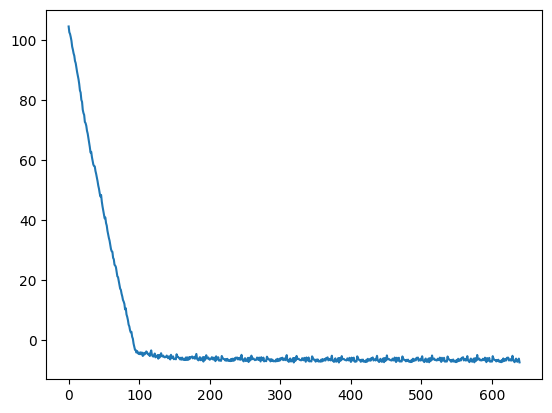

38


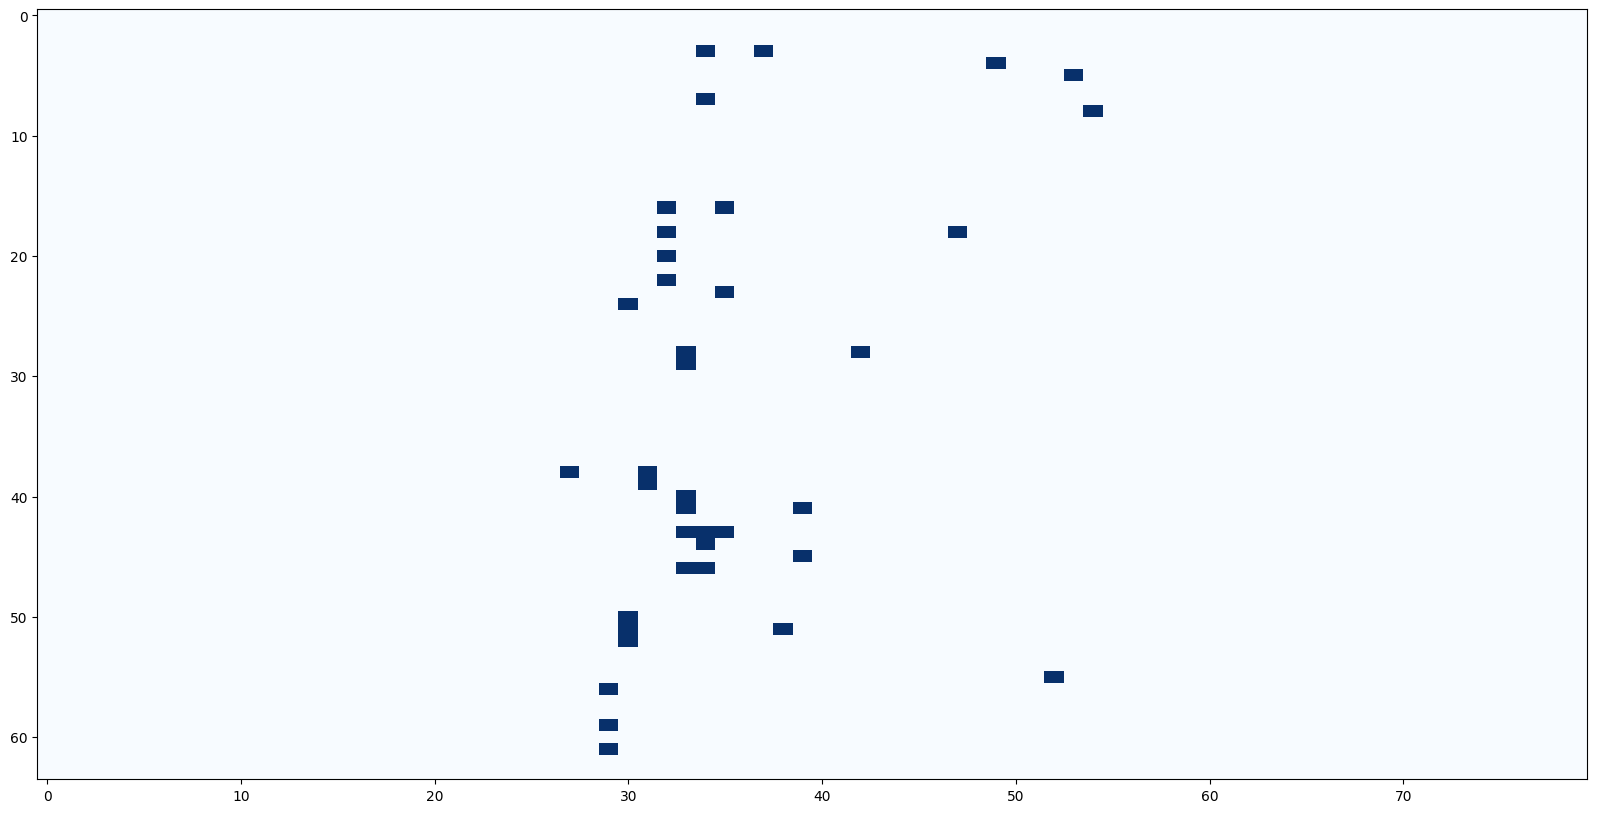

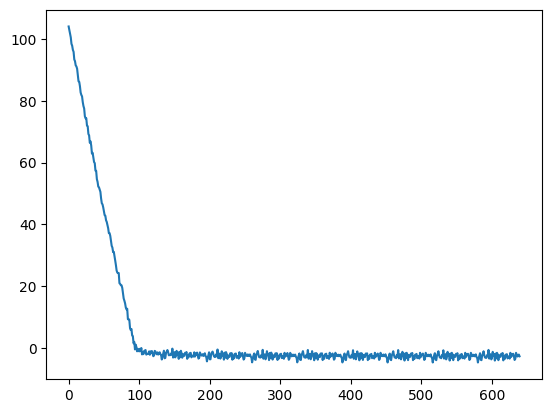

23


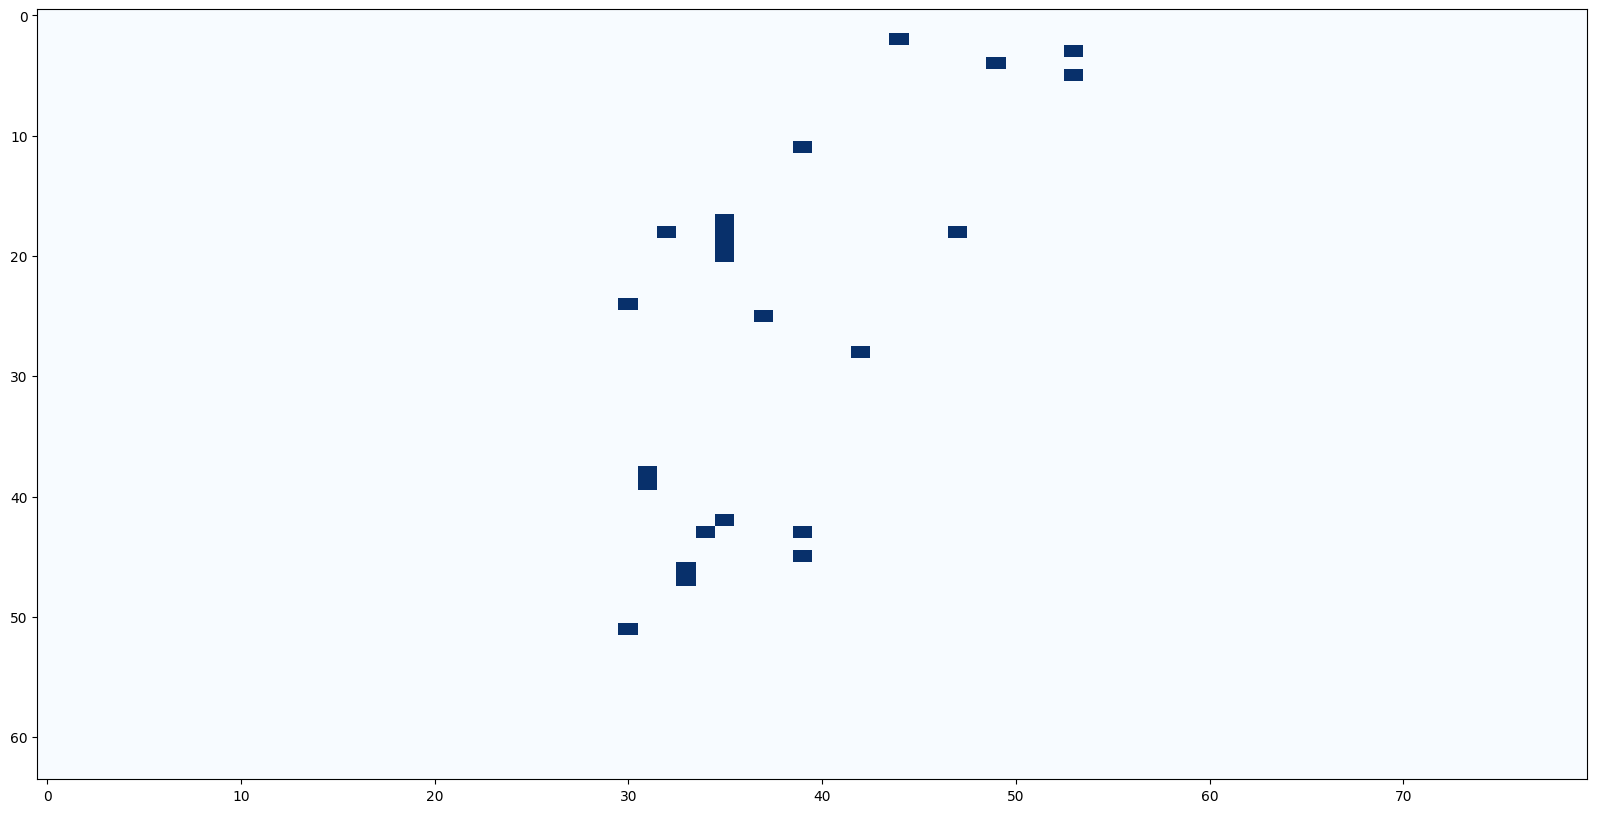

In [85]:
import numpy as np

configs = ["predicate", "pointer"]
heads_selected = {key: None for key in configs}


for config in configs:
    optimized_path = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        f"selection/test_ov_opt_{config}",
        mt.name.split("/")[-1],
        f"{TASK_CLS.task_name}",
        "epoch_10.npz",
    )

    loaded_optimization_results = np.load(optimized_path, allow_pickle=True)
    plt.plot(loaded_optimization_results["losses"])
    plt.show()

    plt.figure(figsize=(20, 10))

    optimal_head_mask = torch.tensor(loaded_optimization_results["optimal_mask"]).to(torch.float32)
    optimal_head_mask[55:, :] = 0.0

    plt.imshow(
        optimal_head_mask.T.numpy(),
        cmap="Blues",
        aspect="auto",
        vmin=0,
        vmax=1,
    )

    optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    optimized_heads = [(layer_idx, head_idx) for layer_idx, head_idx in optimized_heads]
    print(len(optimized_heads))

    heads_selected[config] = optimized_heads

    plt.show()

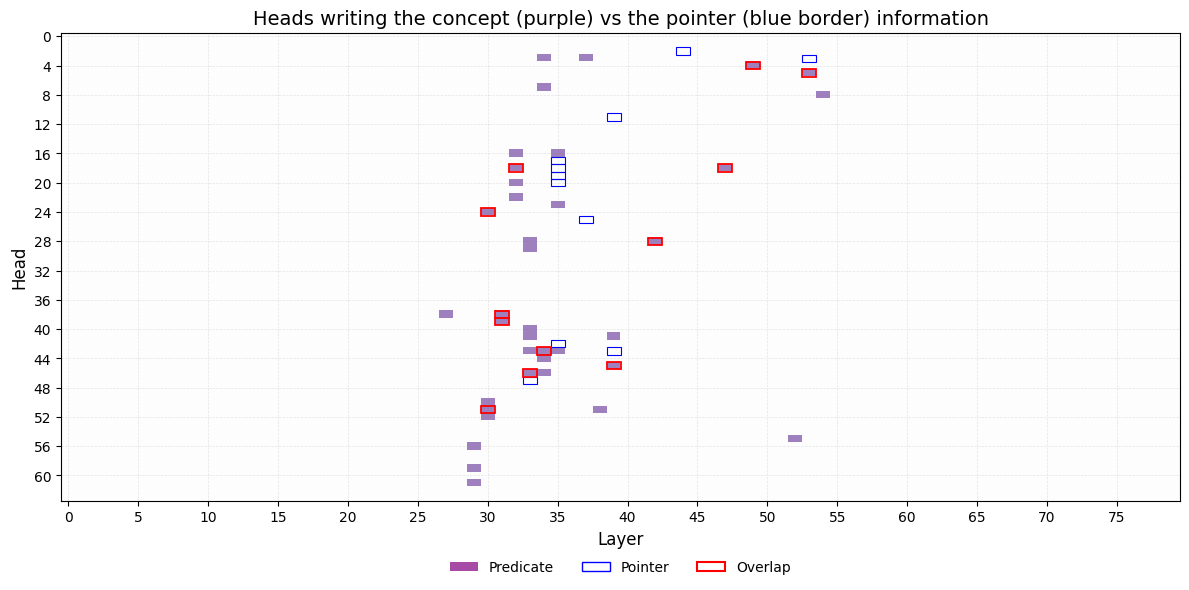

Total heads for predicate: 38
Total heads for pointer: 23
Overlapping heads: 12
Overlapping positions: [(30, 24), (30, 51), (31, 38), (31, 39), (32, 18), (33, 46), (34, 43), (39, 45), (42, 28), (47, 18), (49, 4), (53, 5)]


In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

colors = {
    "predicate": "Purples",
    "pointer": "Blues",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Start with base visualization for predicate heads
predicate_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer))
for layer_idx, head_idx in heads_selected["predicate"]:
    predicate_mask[head_idx, layer_idx] = 1.0

# Plot predicate heads as colored heatmap
im = ax.imshow(
    predicate_mask,
    cmap=colors["predicate"],
    aspect="auto",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    alpha=0.5,
)

# Find overlapping heads
overlapping_heads = []
for head in heads_selected["predicate"]:
    if head in heads_selected["pointer"]:
        overlapping_heads.append(head)

# Draw dark borders for pointer heads (excluding overlaps)
for layer_idx, head_idx in heads_selected["pointer"]:
    if (layer_idx, head_idx) not in overlapping_heads:
        rect = mpatches.Rectangle(
            (layer_idx - 0.5, head_idx - 0.5),
            1,
            1,
            fill=False,
            edgecolor="blue",
            linewidth=0.8,
        )
        ax.add_patch(rect)

# Draw thicker red borders for overlapping heads
for layer_idx, head_idx in overlapping_heads:
    rect = mpatches.Rectangle(
        (layer_idx - 0.5, head_idx - 0.5),
        1,
        1,
        fill=False,
        edgecolor="red",
        linewidth=1.3,
    )
    ax.add_patch(rect)

# Add labels and formatting
ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Head", fontsize=12)
ax.set_title("Heads writing the concept (purple) vs the pointer (blue border) information", fontsize=14)

# Add grid for clarity
ax.set_xticks(np.arange(0, mt.n_layer, 5))
ax.set_yticks(np.arange(0, mt.config.num_attention_heads, 4))
ax.grid(True, alpha=0.2, linestyle="--", color="gray", linewidth=0.5)

# Create custom legend
legend_elements = [
    mpatches.Patch(facecolor="purple", alpha=0.7, label="Predicate"),
    mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=1, label="Pointer"),
    mpatches.Patch(facecolor="white", edgecolor="red", linewidth=1.5, label="Overlap"),
]
ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=10,
    frameon=False,
)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total heads for predicate: {len(heads_selected['predicate'])}")
print(f"Total heads for pointer: {len(heads_selected['pointer'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

## Validation

In [25]:
###############################################################
# HEADS = heads_selected["predicate"]
HEADS = filter_heads
###############################################################
len(HEADS)

79

In [26]:
from tqdm.auto import tqdm

ov_patching_results = []
for destination, source in tqdm(validation_set):
    rand_idx = random.choice(
        list(
            set(range(len(destination.options)))
            - {
                source.obj_idx,
                destination.obj_idx,
                destination.metadata["track_type_obj_idx"],
            }
        )
    )
    track_tokens = {
        "destination_obj": get_first_token_id(
            name=destination.obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        "destination_obj_label": destination.ans_token_id,
        "source_obj": get_first_token_id(
            name=source.obj, tokenizer=mt.tokenizer, prefix=" "
        ),
        "source_obj_label": source.ans_token_id,
        "target_obj": get_first_token_id(
            name=destination.metadata["track_type_obj"],
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
        "target_obj_label": destination.metadata["track_type_obj_token_id"],
        # pointer
        "pointer_obj": get_first_token_id(
            name=destination.options[source.obj_idx], tokenizer=mt.tokenizer, prefix=" "
        ),
        "pointer_obj_label": get_first_token_id(
            name=chr(ord(destination.option_label_start_from) + source.obj_idx),
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
        # random distractor
        "rand_obj": get_first_token_id(
            name=source.options[rand_idx], tokenizer=mt.tokenizer, prefix=" "
        ),
        "rand_obj_label": get_first_token_id(
            name=chr(ord(source.option_label_start_from) + rand_idx),
            tokenizer=mt.tokenizer,
            prefix=" ",
        ),
    }

    ret_dict = validate_ov_patching_on_sample_pair(
        mt=mt,
        destination_sample=destination,
        source_sample=source,
        token_mapping={-1: -1},
        heads = HEADS,
        must_track_tokens=list(track_tokens.values()),
        return_clean_predictions=True,
        debug=False,
    )

    ov_patching_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": ret_dict["patched_predictions"],
            "patched_track": ret_dict["patched_track"],
            "destination_pred": ret_dict["destination_predictions"],
            "destination_track": ret_dict["destination_track"],
            "track_tokens": track_tokens,
        }
    )


  0%|          | 0/512 [00:00<?, ?it/s]

In [27]:
sample_idx = 6
source_sample = ov_patching_results[sample_idx]["source"]
destination_sample = ov_patching_results[sample_idx]["destination"]
track_tokens = ov_patching_results[sample_idx]["track_tokens"]

print("Source:", source_sample.prompt(), ">>", source_sample.obj, ">>", mt.tokenizer.decode(source_sample.ans_token_id))
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj, ">>", mt.tokenizer.decode(destination_sample.ans_token_id))
print("\nPatched Predictions:")

for key, token_id in track_tokens.items():
    print(f"{key}: {mt.tokenizer.decode(token_id)} [{token_id}]")

Source: p. Birch
q. Microwave
r. Shorts
s. Desk
t. Binder
u. Drum
v. Shower
w. Dog
Which among these objects mentioned above is a music instrument?
Answer: >> Drum >>  u
Destination: a. Binder
b. Shorts
c. Drum
d. Birch
e. Shower
f. Desk
g. Microwave
h. Dog
Which among these objects mentioned above is a tree?
Answer: >> Birch >>  d

Patched Predictions:
destination_obj:  Birch [88088]
destination_obj_label:  d [294]
source_obj:  Drum [46506]
source_obj_label:  u [577]
target_obj:  Drum [46506]
target_obj_label:  c [272]
pointer_obj:  Desk [39794]
pointer_obj_label:  f [282]
rand_obj:  Birch [88088]
rand_obj_label:  p [281]


In [28]:
from src.selection.data import get_options_for_answer
get_options_for_answer(destination_sample)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [29]:
passed = 0
for result in ov_patching_results:
    track_tokens = result["track_tokens"]
    target_tokens = [track_tokens["target_obj_label"], track_tokens["target_obj"]]
    # target_tokens = [track_tokens["pointer_obj_label"], track_tokens["pointer_obj"]]

    patched_track = result["patched_track"]
    if (
        patched_track[list(patched_track.keys())[0]][1].token_id in target_tokens
    ):
        passed += 1

causality = passed / len(ov_patching_results)
print(f"Causality = {causality:.3f} ({passed}/{len(ov_patching_results)})",)

Causality = 0.439 (225/512)


In [30]:
import numpy as np

track_token_types = list(ov_patching_results[0]["track_tokens"].keys())
scores_by_token_type = {token_type: {} for token_type in track_token_types}

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in ov_patching_results:
        # if result['destination'].option_label_start_from != 'p':
        #     continue

        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        # logger.info(f"{target_tok_id=} | {result['patched_track'].keys()=}")
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }

    scores_by_token_type[token_type] = attr
    for target_concept in attr:
        clean = np.array(attr[target_concept]["clean"])
        patch = np.array(attr[target_concept]["patch"])
        delta = patch - clean
        print(f"{target_concept}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}")
    

destination_obj
rank: clean 4.12 ± 2.38 -> patch 1820.04 ± 3866.95 | delta 1815.91 ± 3866.66
logit: clean 18.31 ± 1.22 -> patch 8.09 ± 2.59 | delta -10.22 ± 2.81
destination_obj_label
rank: clean 1.00 ± 0.04 -> patch 41.82 ± 30.68 | delta 40.82 ± 30.67
logit: clean 21.07 ± 0.82 -> patch 13.42 ± 1.84 | delta -7.66 ± 1.81
source_obj
rank: clean 986.42 ± 2917.86 -> patch 172.72 ± 598.00 | delta -813.70 ± 2886.85
logit: clean 9.44 ± 2.76 -> patch 14.18 ± 3.80 | delta 4.74 ± 4.24
source_obj_label
rank: clean 281.03 ± 319.87 -> patch 261.13 ± 329.63 | delta -19.89 ± 199.42
logit: clean 10.89 ± 2.85 -> patch 11.51 ± 3.44 | delta 0.62 ± 1.39
target_obj
rank: clean 986.42 ± 2917.86 -> patch 172.72 ± 598.00 | delta -813.70 ± 2886.85
logit: clean 9.44 ± 2.76 -> patch 14.18 ± 3.80 | delta 4.74 ± 4.24
target_obj_label
rank: clean 28.54 ± 23.00 -> patch 9.48 ± 15.03 | delta -19.05 ± 26.25
logit: clean 14.31 ± 1.80 -> patch 17.76 ± 2.80 | delta 3.46 ± 3.16
pointer_obj
rank: clean 988.76 ± 2651.43 -> 

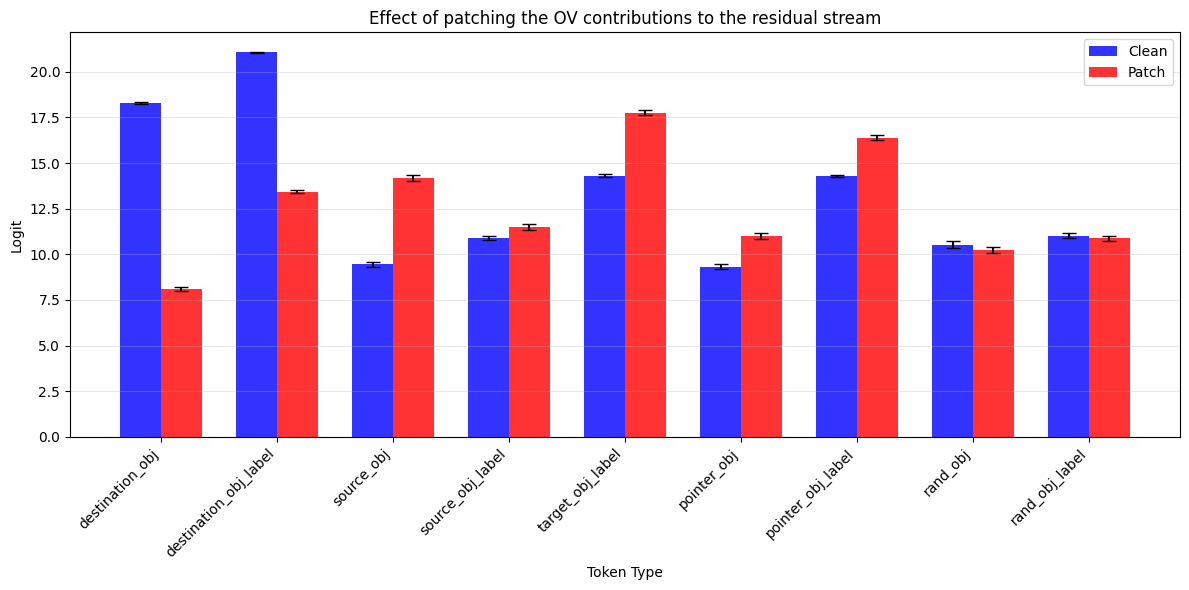

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Extract logit data for each token type
token_types = list(scores_by_token_type.keys())
token_types = [token_type for token_type in token_types if token_type != "target_obj"]

clean_logits_mean = []
clean_logits_std = []
patch_logits_mean = []
patch_logits_std = []

for token_type in token_types:
    clean_data = np.array(scores_by_token_type[token_type]["logit"]["clean"])
    patch_data = np.array(scores_by_token_type[token_type]["logit"]["patch"])
    
    clean_logits_mean.append(clean_data.mean())
    clean_logits_std.append(clean_data.std() / len(clean_data)**0.5)  # SEM
    patch_logits_mean.append(patch_data.mean())
    patch_logits_std.append(patch_data.std() / len(patch_data)**0.5)  # SEM

# Set up the bar chart
x = np.arange(len(token_types))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars1 = ax.bar(x - width/2, clean_logits_mean, width, 
               yerr=clean_logits_std, label='Clean', 
               capsize=5, alpha=0.8, color='blue')
bars2 = ax.bar(x + width/2, patch_logits_mean, width, 
               yerr=patch_logits_std, label='Patch', 
               capsize=5, alpha=0.8, color='red')

# Customize the chart
ax.set_xlabel('Token Type')
ax.set_ylabel('Logit')
ax.set_title('Effect of patching the OV contributions to the residual stream')
ax.set_xticks(x)
ax.set_xticklabels(token_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

2025-10-29 00:12:45 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-10-29 00:12:45 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-10-29 00:12:45 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


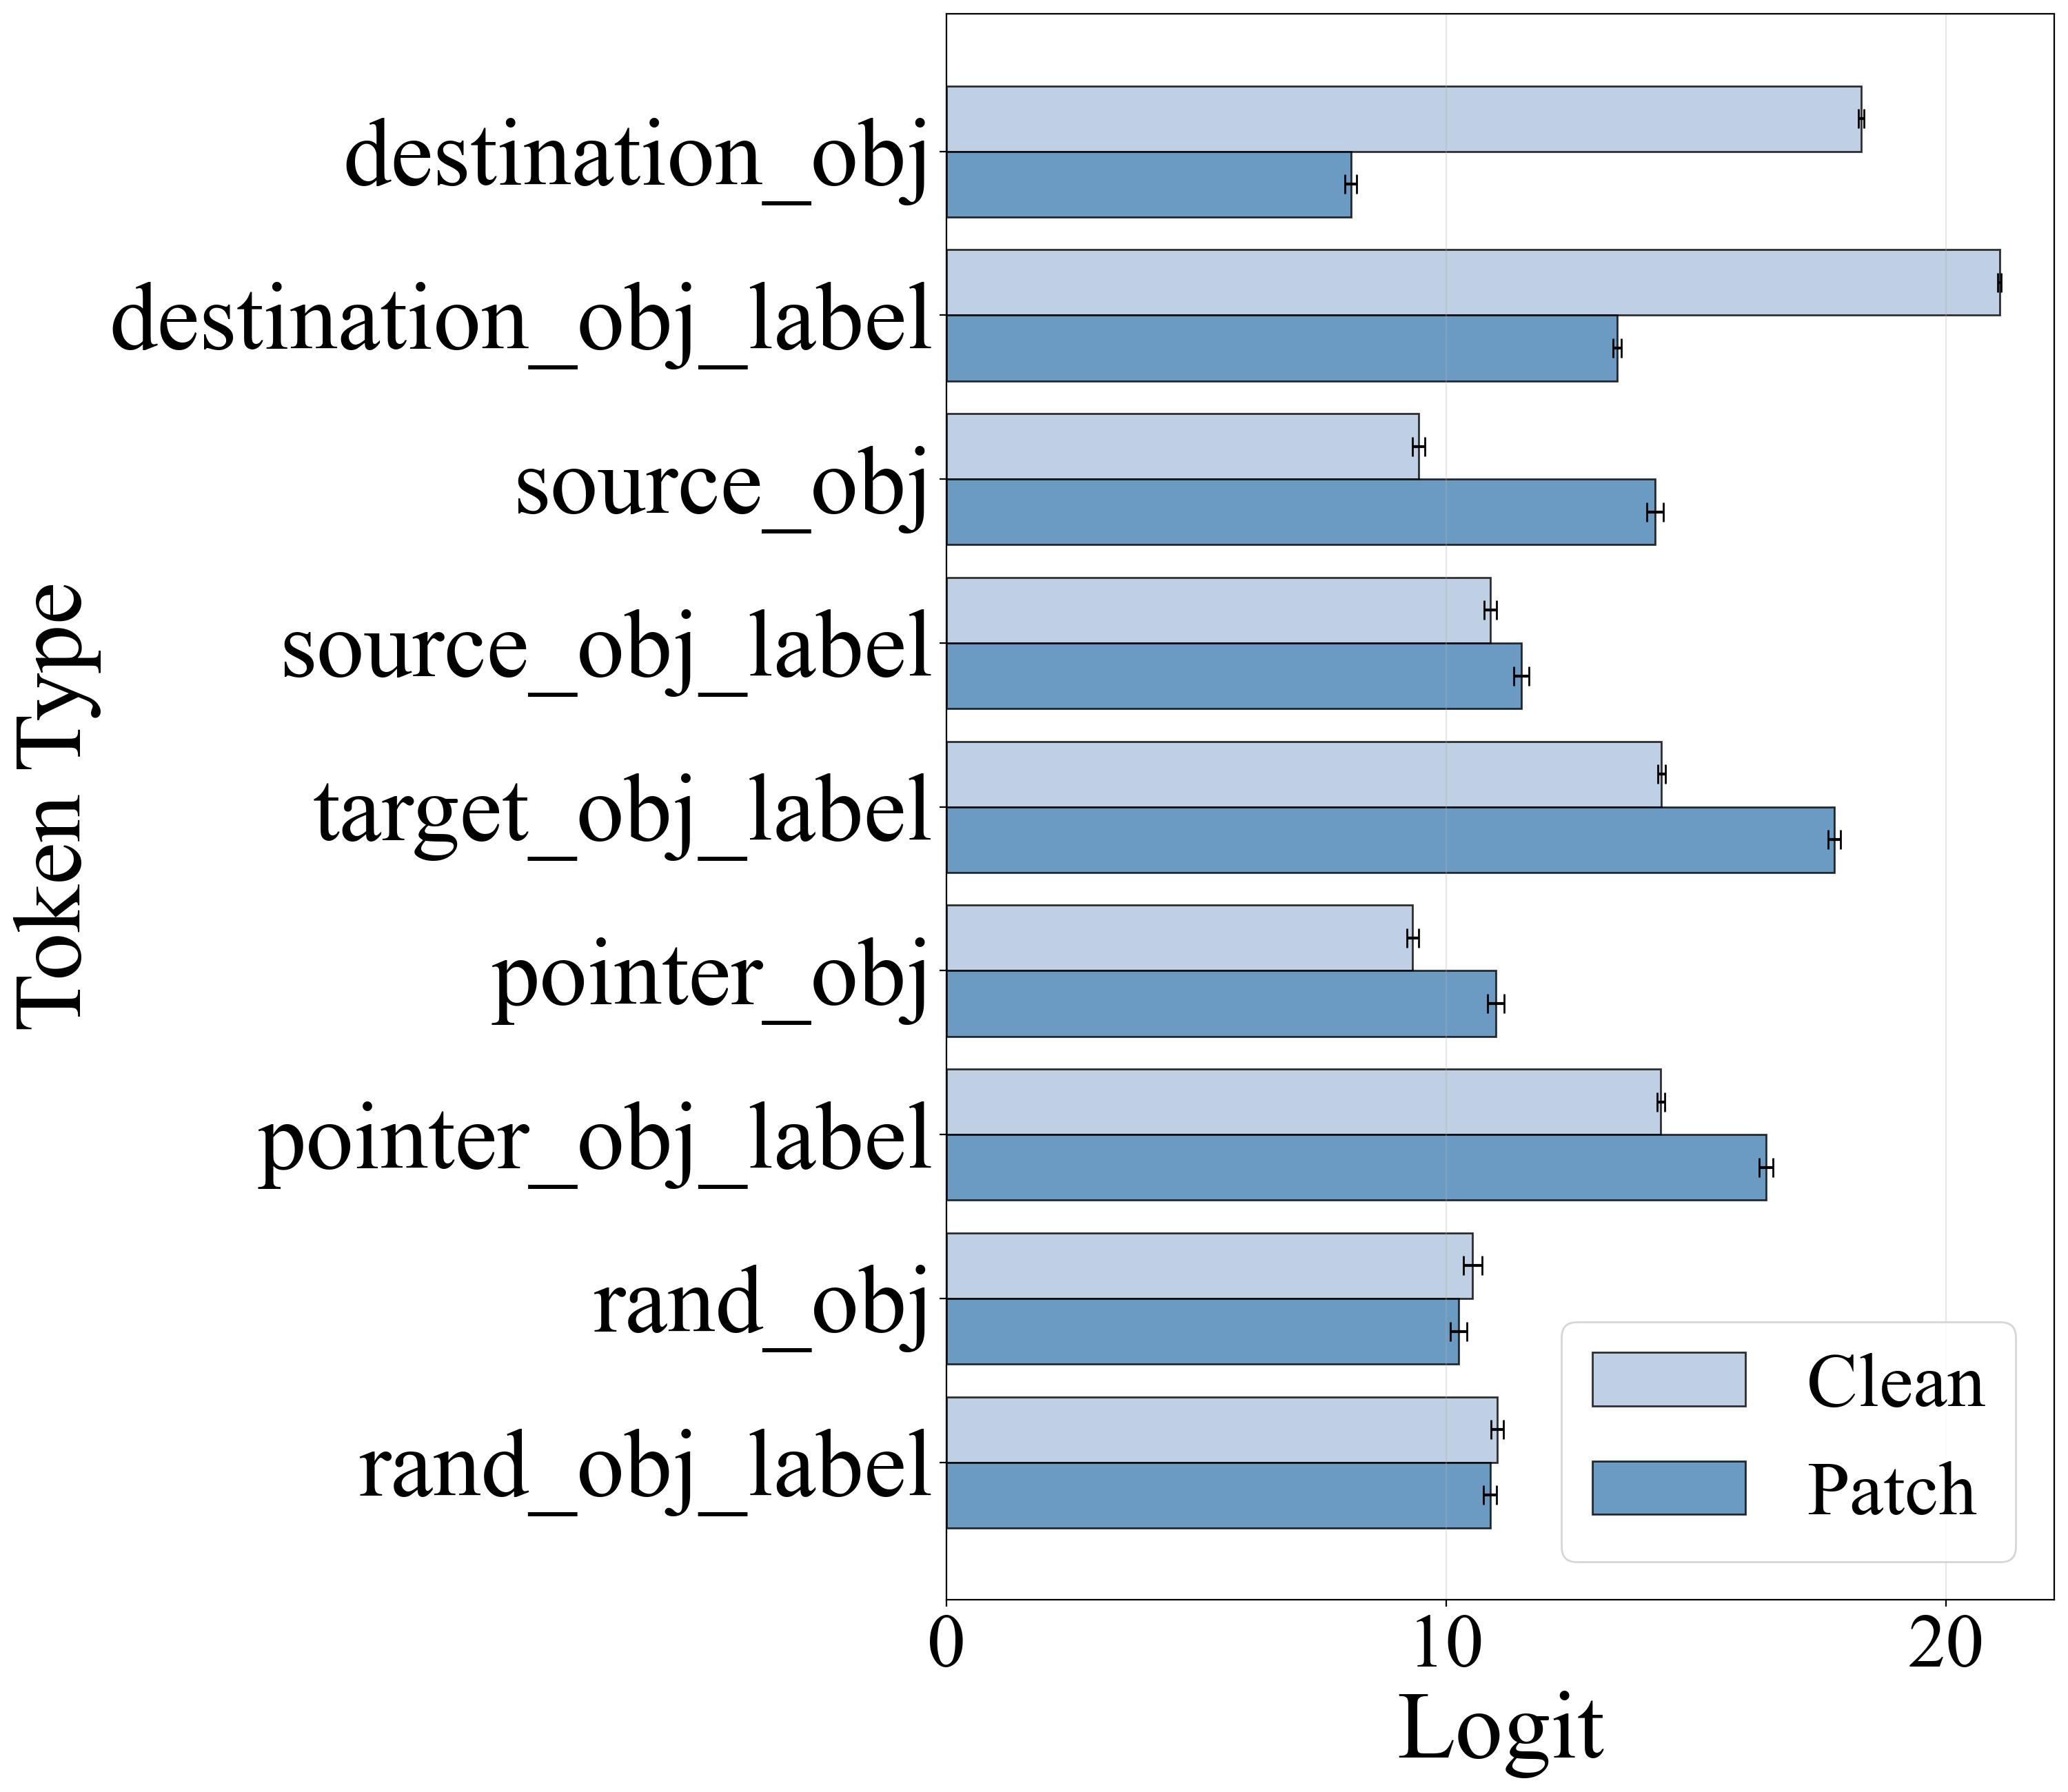

In [57]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 40
MEDIUM_SIZE = 50
BIGGER_SIZE = 55+5

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Extract logit data for each token type
token_types = list(scores_by_token_type.keys())
token_types = [token_type for token_type in token_types if token_type != "target_obj"][
    ::-1
]

clean_logits_mean = []
clean_logits_std = []
patch_logits_mean = []
patch_logits_std = []

for token_type in token_types:
    clean_data = np.array(scores_by_token_type[token_type]["logit"]["clean"])
    patch_data = np.array(scores_by_token_type[token_type]["logit"]["patch"])

    clean_logits_mean.append(clean_data.mean())
    clean_logits_std.append(clean_data.std() / len(clean_data) ** 0.5)  # SEM
    patch_logits_mean.append(patch_data.mean())
    patch_logits_std.append(patch_data.std() / len(patch_data) ** 0.5)  # SEM

# Set up the bar chart
y = np.arange(len(token_types))  # Label locations
width = 0.4  # Width of bars (reduced from 0.35)

fig, ax = plt.subplots(figsize=(16, 14))

# Create horizontal bars
bars1 = ax.barh(
    y + width / 2,
    clean_logits_mean,
    width,
    xerr=clean_logits_std,
    label="Clean",
    capsize=5,
    alpha=0.8,
    color="lightsteelblue",
    edgecolor = "black"
)
bars2 = ax.barh(
    y - width / 2,
    patch_logits_mean,
    width,
    xerr=patch_logits_std,
    label="Patch",
    capsize=5,
    alpha=0.8,
    color="steelblue",
    edgecolor = "black"
)

# Customize the chart
ax.set_ylabel("Token Type")
ax.set_xlabel("Logit")
# ax.set_title("Effect of patching the OV contributions to the residual stream")
ax.set_yticks(y)
ax.set_yticklabels(token_types)
ax.legend()
ax.grid(axis="x", alpha=0.3)

fig_save_path = os.path.join("figures", model_key.split("/")[-1])
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, "ov_patching_filter_heads.pdf"), bbox_inches='tight', pad_inches=0)

plt.show()